# Metaplectic Geometrical Optics with Analytic Continuation

This Notebook (created on October 15th 2024) demonstrates the new algorithm of metaplectic geometrical optics, which uses complex ray tracing to calculate the analytic continuations needed for the steepest descent integrals when evaluating the inverse metaplectic transform.

In [5]:
import torch
from torch_helper import torch_func, to_torch, grad, nth_grad
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid
import util as ut

## 1. Define Dispersion Relation

In [6]:
ND = 1

@torch_func
def D(z: ('tensor', {'dtype': torch.complex64}), omega: ('tensor', {'dtype': torch.complex64})):
    x, k = (z[:ND], z[ND:])
    return x + k**2

## 2. Trace ray

In this file I demonstrate the analytic implementation on the Airy Problem:
$$
x \psi(x) - \partial_x^2 \psi(x)  = 0.
$$
The corresponding local dispersion relation for Airy's equation is:
$$
\mathcal{D}(x, k) = x + k^2 = 0
$$

In [7]:
import numpy as np
import torch
# from torch.autograd import grad
from scipy.integrate import solve_ivp
from warnings import warn

def get_boundary_events_1D(x_min, x_max, atol):
    events = []

    if (x_min is not None):
        def hit_min(t, q):
            return np.min(q[0] - (x_min - atol))
        hit_min.terminal = True
        hit_min.direction = -1
        events.append(hit_min)
    
    if (x_max is not None):
        def hit_max(t, q):
            return np.min((x_max + atol) - q[0])
        hit_max.terminal = True
        hit_max.direction = -1
        events.append(hit_max)
    
    return events

@torch_func
def dzdt(z: ('tensor', {'dtype': torch.complex64}, 'requires_grad'), omega0: ('tensor', {'dtype': torch.complex64}), D: ('any'), D_args: ('any')={}):
    dDdz = grad(D(z, omega0, **D_args), z)
    J = torch.tensor([[0.0, 1.0],
                      [-1.0, 0.0]], dtype=torch.complex64)
    return (J @ dDdz).resolve_conj().detach().numpy()

def get_zdots(zs, omega0):
    zdots = np.array([dzdt(z, omega0, D) for z in zs])
    xdots, kdots = (zdots[..., :ND], zdots[..., ND:])
    return zdots, xdots, kdots

def trace_ray_1D(x0, k0, omega0, tmin, tmax, D, D_args={}, rtol=1e-3, x_min=None, x_max=None, tsteps=500, solve_ivp_args={}):
    ND = 1 # We trace in 1D
    z0 = np.hstack((x0, k0), dtype=np.complex64)
    
    # RHS of ray-tracer ODE
    def f(t, z):
        return dzdt(z, omega0, D, D_args)
    
    t_eval = np.linspace(tmin, tmax, tsteps)
    sol = solve_ivp(f, [tmin, tmax], z0, t_eval = t_eval, events=get_boundary_events_1D(x_min, x_max, atol=(1e-3)*rtol), rtol=rtol, atol = (1e-3)*rtol, **solve_ivp_args)

    if not sol.success:
        warn(sol.message)
        return
    
    ts = sol.t
    xs = sol.y[:ND].T
    ks = sol.y[ND:].T
    zs = np.concatenate([xs, ks], axis=-1)

    # ray tracing stops when it hits boundary, so we don't know
    # exact number of timesteps before ray tracing has completed.
    nt = len(ts)
    return ts, xs, ks, zs, nt

In [8]:
from scipy.special import airy

# Exact solution gives initial conditions
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi
x0 = -8
k0 = np.sqrt(-x0)
phi0 = Ai(x0)
omega0 = 1.0
ts, xs, ks, zs, nt = trace_ray_1D(x0, k0, omega0, tmin=0, tmax=2*k0, D=D, tsteps=500)

interactive(children=(IntSlider(value=0, description='it', max=499), Output()), _dom_classes=('widget-interact…

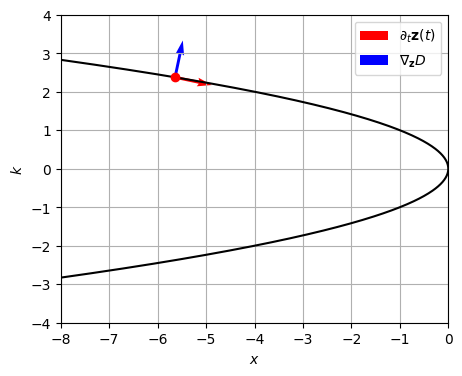

In [16]:
from ipywidgets import interact, IntSlider, Play, jslink, HBox

def plot_ray(it):
    plt.figure(figsize=(5, 4))
    plt.plot(np.real(xs), np.real(ks), 'k-')
    # plt.plot(np.imag(xs), np.imag(ks), 'b--')
    plt.plot(np.real(xs[it]), np.real(ks[it]), 'ro')
    zdot = np.real(dzdt(zs[it], 1.0, D))
    plt.quiver(*np.real(zs[it]).reshape(-1, 1), zdot[0], zdot[1], color='red', scale=5e1, label=r'$\partial_t \mathbf{z}(t)$')
    plt.quiver(*np.real(zs[it]).reshape(-1, 1), -zdot[1], zdot[0], color='blue', scale=5e1, label=r'$\nabla_\mathbf{z} D$')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$k$')
    plt.legend(loc='upper right')
    plt.xlim(-8, 0)
    plt.ylim(-4, 4)
    plt.grid()

slider = IntSlider(value=0, min=0, max=len(ts)-1, step=1)
interact(plot_ray, it=slider)
plt.show()

plot_ray(it=40)
plt.savefig('./plots/airy_ray_trace.svg')
plt.savefig('./plots/airy_ray_trace.pdf')

## 3. Determine Symplectic Transformation

In [17]:
def S(z):
    zdot = dzdt(z, omega0, D)
    xdot = zdot[:ND]
    kdot = zdot[ND:]
    At = xdot/(xdot**2 + kdot**2)**(1/2)
    Bt = kdot/(xdot**2 + kdot**2)**(1/2)
    _S = np.block([[At, Bt], [-Bt, At]])
    return _S

In [18]:
def plot_rotated_disp_curve(it):
    xmin, xmax = -9, 9
    fig, ax = plt.subplots(1, 2, width_ratios=[1, 1], figsize=(8, 4))
    ax[0].plot(np.real(xs), np.real(ks), 'k-')
    ax[0].plot(np.real(xs[it]), np.real(ks[it]), 'ro')
    ax[0].grid()
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(xmin, xmax)
    ax[0].set_xlabel(r'$x$')
    ax[0].set_ylabel(r'$k$')

    St = S(zs[it])
    Zs = (St @ zs.T).T
    Xs, Ks = (Zs[:, 0], Zs[:, 1])

    Zt = Zs[it]
    Xt, Kt = Zt
    
    zt = zs[it]
    xt, kt = zt

    ax[1].plot(np.real(Xs), np.real(Ks), '-', color='tab:orange')
    ax[1].plot([xmin, xmax], np.real(Ks[it])*np.ones_like([xmin, xmax]), '--', color='gray')
    ax[1].plot([np.real(Xs[it])], np.real(Ks[it]), 'ro')
    ax[1].grid()
    ax[1].set_xlim(xmin, xmax)
    ax[1].set_ylim(xmin, xmax)
    ax[1].set_xlabel(r'$X$')
    ax[1].set_ylabel(r'$K$')

    plt.tight_layout()

slider = IntSlider(value=0, min=0, max=len(ts)-1, step=1)
interact(plot_rotated_disp_curve, it=slider)
plt.show()

interactive(children=(IntSlider(value=0, description='it', max=499), Output()), _dom_classes=('widget-interact…

## 4. Analytic Continuation and Steepest Descent Algorithm

The code below implements all functions required to do the analytic continuation

In [19]:
from scipy.interpolate import interp1d
from baryrat import aaa
import math
from scipy.special import gamma as Gamma

def get_branches(J):
    branch_masks = ut.get_masks_of_const_sgn(np.real(J), ND=1)
    J_desc = np.argsort(np.abs(J))[::-1]
    seeds = []
    branch_ranges = []
    for branch in branch_masks:
        branch_min, branch_max = np.min(np.argwhere(branch)), np.max(np.argwhere(branch))
        seed = J_desc[(branch_min <= J_desc) & (J_desc <= branch_max)][0]

        range_back, range_forward = range(seed, max(branch_min -1, -1), -1), range(seed, min(branch_max + 1, J.shape[0]), +1)
        if len(range_back) > 1:
            branch_ranges.append(range_back)
            seeds.append(seed - 1)
        if len(range_forward) > 1:
            branch_ranges.append(range_forward)
            seeds.append(seed)
    return branch_masks, seeds, branch_ranges

def S(z):
    zdot = dzdt(z, omega0, D)
    xdot = zdot[:ND]
    kdot = zdot[ND:]
    At = xdot/(xdot**2 + kdot**2)**(1/2)
    Bt = kdot/(xdot**2 + kdot**2)**(1/2)
    _S = np.block([[At, Bt], [-Bt, At]])
    return _S

def Z(S, z):
    return S @ z

@torch_func
def dDdZ(Z: ('tensor', {'dtype': torch.complex64}, 'requires_grad'), St: ('tensor', {'dtype': torch.complex64})):
    z = St.T @ Z
    dDdz = grad(D(z, omega0), z)
    return St @ dDdz

@torch_func
def dKdX(Z: ('tensor', {'dtype': torch.complex64}, 'requires_grad'), St: ('tensor', {'dtype': torch.complex64})):
    _dDdZ = dDdZ(Z, St)
    dDdX, dDdK = (_dDdZ[:ND], _dDdZ[ND:])
    return -dDdX/dDdK

@torch_func
def dnfdXn(Z: ('tensor', {'dtype': torch.complex64}, 'requires_grad'), Zt: ('tensor', {'dtype': torch.complex64}), St: ('tensor', {'dtype': torch.complex64}), n: ('any')):
    assert n >= 1, "n should be greater or equal to 1 when calling the derivative function dnfdXn()"

    X, K = (Z[:ND].clone(), Z[ND:].clone())
    Z = torch.hstack((X, K))
    Xt, Kt = (Zt[:ND], Zt[ND:])
    At = St[0, 0]
    Bt = St[0, 1]

    if n == 1:
        return ((K - Kt) - At/Bt * (X - Xt)).resolve_conj().detach().numpy()
    if n >= 2:
        return nth_grad(dKdX(Z, St) - At/Bt, X, n-2).resolve_conj().detach().numpy()

def get_n_and_dnf(Z, Zt, St, atol=1e-3):
    n = 1
    dnf = dnfdXn(Z, Zt, St, n)
    dnpf = dnfdXn(Z, Zt, St, n + 1)
    while np.isclose(np.abs(dnf/dnpf), 0, atol=atol):
        n = n + 1
        dnf = dnpf
        dnpf = dnfdXn(Z, Zt, St, n+1)
        if n >= 3:
            continue
    return n, dnf

def sigma_ms(dnf, n):
    alpha_n = np.angle(dnf)
    sigma_ms = (np.pi - 2*alpha_n)/(2*n) + 2*np.pi/n * np.arange(n)
    return sigma_ms

def sigma_pm(dnf, n):
    _sigma_ms = sigma_ms(dnf, n)
    mp = np.argmin(np.abs(np.exp(1j*_sigma_ms) - 1))
    mm = np.argmin(np.abs(np.exp(1j*_sigma_ms) + 1))
    sp, sm = (_sigma_ms[mp], _sigma_ms[mm])
    return sp, sm

def interpolate_eikonal(x, field, interpolation_args):
    phi = np.abs(field)
    theta = ut.continuous_angle(field)
    r_phi = aaa(x, phi, **interpolation_args)
    r_theta = aaa(x, theta, **interpolation_args)
    r = lambda x: r_phi(x) * np.exp(1j*r_theta(x))
    return r

def get_A0_and_interpolation(phi0, x0, xs, branch_masks, ray_field, interpolation_method='linear', interpolation_args={}):
    '''returns A0, interp_field needed to superpose ray fields satisfying boundary condition.
    interpolation_method must one of 'eikonal_baryrat', 'baryrat' for a barycentric rational interpolation
        or alternatively one of 'linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic',
        'previous' or 'next' to use scipy's interp1d interpolation function.
    '''
    if interpolation_method in ['linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next']:
        branches = [interp1d(xs[mask].squeeze(), ray_field[mask], kind=interpolation_method, bounds_error=False, fill_value='extrapolate', **interpolation_args) for mask in branch_masks]
    elif interpolation_method == 'eikonal_baryrat':
        branches = [interpolate_eikonal(xs[mask].squeeze(), ray_field[mask], interpolation_args=interpolation_args) for mask in branch_masks]
    elif interpolation_method == 'baryrat':
        branches = [aaa(xs[mask].squeeze(), ray_field[mask], **interpolation_args) for mask in branch_masks]

    def interp_field(x):
        return sum(f(x) for f in branches)

    A0 = phi0/interp_field(x0)

    return A0, interp_field

def superpose_ray_fields(phi0, x0, xs, branch_masks, ray_field, interpolation_method='linear', interpolation_args={}):
    '''returns interpolated function `field` 
        interpolation_method must one of 'eikonal_baryrat', 'baryrat' for a barycentric rational interpolation
        or alternatively one of 'linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic',
        'previous' or 'next' to use scipy's interp1d interpolation function.
        '''
    A0, interp_field = get_A0_and_interpolation(phi0, x0, xs, branch_masks, ray_field, interpolation_method=interpolation_method, interpolation_args=interpolation_args)

    def field(x):
        return A0 * interp_field(x)
    
    return field

def get_Ns(zs, zdots, ts):
    ks = zs[..., ND:]
    xdots, kdots = (zdots[..., :ND], zdots[..., ND:])
    thetas = cumulative_trapezoid(ks * xdots, ts, initial=0, axis=0)
    _Ns = np.exp(1j * (
        thetas
    )) / (ut.continuous_sqrt_of_reals(np.real(kdots)))
    return _Ns

def Zdot(t, Z, Zt, St, l_sign):
    assert l_sign in [-1, 1]
    _Z = to_torch(Z, dtype=torch.complex64, requires_grad=True)
    _Zt, _St = to_torch(Zt, St, dtype=torch.complex64)
    n, dnf = get_n_and_dnf(_Z, _Zt, _St, atol=0.5e-2)
    sp, sm = sigma_pm(dnf, n)
    _dDdZ = dDdZ(Z, St).resolve_conj().detach().numpy()
    dDdX, dDdK = _dDdZ[0], _dDdZ[1]
    if l_sign == 1:
        return np.exp(1j*sp) * np.array([1, -dDdX/dDdK])
    else:
        return np.exp(1j*sm) * np.array([1, -dDdX/dDdK])
    
def Thetas(Zs):
    return cumulative_trapezoid(Zs[..., 1], Zs[..., 0], initial=0, axis=0)

def get_fs(Zs, Zt, St):
    At = St[0, 0]
    Bt = St[0, 1]
    Kt = Zt[1]
    deltaXs = Zs[..., 0] - Zt[0]
    return Thetas(Zs) - 1/2 * At/Bt * deltaXs**2 - Kt * deltaXs

def Phi_non_norm(Z, St):
    _dDdZ = dDdZ(Z, St)
    _dDdK = _dDdZ[ND:].resolve_conj().detach().numpy()
    return (_dDdK)**(-1/2)

def get_Phis(Zs, St):
    Phis_non_norm = np.array([Phi_non_norm(Z, St) for Z in Zs])
    Phis = Phis_non_norm/Phis_non_norm[0]
    return Phis.squeeze()

def get_integrand(Zs, Zt, St):
    Phis = get_Phis(Zs, St)
    fs = get_fs(Zs, Zt, St)
    return Phis * np.exp(1j*fs)

def cray(Zt, St, l_sign, lmin, lmax, nl):
    l_eval = np.linspace(lmin, lmax, nl)
    sol = solve_ivp(Zdot, (lmin, lmax), Zt, t_eval=l_eval, args=(Zt, St, l_sign), atol=1e-9)
    ls = sol.t
    Xsl = sol.y[:ND].T
    Ksl = sol.y[ND:].T
    Zsl = np.concatenate([Xsl, Ksl], axis=-1)
    return ls, Zsl, Xsl, Ksl

def U(Zt, St):
    lmin, lmax, nl = 0, 3, 10

    integrals = []
    for l_sign in [-1, 1]:
        ls, Zsl, Xsl, Ksl = cray(Zt, St, l_sign, lmin, lmax, nl)
        integrand = get_integrand(Zsl, Zt, St)
        integrals.append(np.trapezoid(integrand, l_sign*Xsl.squeeze()))
    _U = sum(integrals)
    return _U

def get_Us(zs):
    Us = np.zeros((zs.shape[0], 1), dtype=np.complex64)
    for i, z in enumerate(zs):
        print(i, end='\r', flush=True)
        St = S(z)
        Zt = Z(St, z)
        Us[i] = U(Zt, St)
    return Us


vt = lambda kt: (1 + 4*kt**2)**(1/2)
def ft(X, Xt, kt):
    return (
        -vt(kt)**3/(8*kt**2) * (X-Xt)
        + vt(kt)**2/(4*kt) * (X-Xt)**2
        + (vt(kt)**6 - (vt(kt)**4 - 8 * kt * vt(kt) * (X-Xt))**(3/2))
        / (
            96 * kt**3
        )
    )

Theta_ex = lambda X, Xt, kt: (
    (8*kt**4 - vt(kt)**4)/(8*kt**2 * vt(kt)) * (X - Xt)**2
    + 1/(4*kt) * (X - Xt)**2
    + vt(kt)**6 - (vt(kt)**4 - 8*kt*vt(kt)*(X-Xt))**(3/2)/(96*kt**3)
    )

Phi_ex = lambda X, Xt, kt: vt(kt)/((vt(kt)**4 - 8*kt*vt(kt)*(X-Xt))**(1/4))

## 5. Field within Stationary Phase Approximation

To check that the complex automatic differentiation works, I first calculate the result within the stationary phase approximation.

In [20]:
##### SPA APPROACH
def U_SPA(Zt, St):
    n, dnf = get_n_and_dnf(Zt, Zt, St)
    sp, sm = sigma_pm(dnf, n)
    U = ((np.exp(1j*sp) - np.exp(1j*sm)) * np.abs(math.factorial(n) / dnf)**(1/n) * (1/n) * Gamma(1/n))[0]
    return U

def get_Us_SPA(zs):
    Us = np.zeros((zs.shape[0], 1), dtype=np.complex64)
    for i, z in enumerate(zs):
        St = S(z)
        Zt = Z(St, z)
        Us[i] = U_SPA(Zt, St)
    return Us

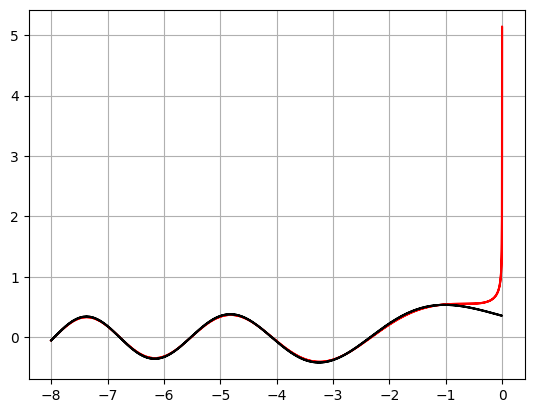

In [21]:
zdots, xdots, kdots = get_zdots(zs, omega0)
branch_masks, seeds, branch_ranges = get_branches(xdots)
Us = get_Us_SPA(zs)
Ns = get_Ns(zs, zdots, ts)
ray_field = Ns * Us

field = superpose_ray_fields(phi0, x0, xs, branch_masks, ray_field)

plt.figure()
plt.plot(np.real(xs), np.real(field(xs)), 'r-')
plt.plot(np.real(xs), Ai(np.real(xs)), 'k-')
plt.grid()
plt.savefig('./plots/airy_mgo_spa.pdf')

## 6. Automatic Analytic Continuation Algorithm in interactive Action

Next, I show the analytic continuation and steepest descent algorithm in action below.

In [28]:
from ipywidgets import interact, IntSlider, Play, jslink, HBox

def sliding_plot(it):
    xmin, xmax = -9, 9
    fig, ax = plt.subplots(2, 3, width_ratios=[1, 1, 1], figsize=(8, 4))
    ax[0, 0].plot(np.real(xs), np.real(ks), 'k-')
    ax[0, 0].plot(np.real(xs[it]), np.real(ks[it]), 'ro')
    ax[0, 0].grid()
    ax[0, 0].set_xlim(xmin, xmax)
    ax[0, 0].set_ylim(xmin, xmax)
    ax[0, 0].set_xlabel(r'$x$')
    ax[0, 0].set_ylabel(r'$k$')

    St = S(zs[it])
    Zs = (St @ zs.T).T
    Xs, Ks = (Zs[:, 0], Zs[:, 1])

    Zt = Zs[it]
    Xt, Kt = Zt
    
    zt = zs[it]
    xt, kt = zt

    ax[0, 1].plot(np.real(Xs), np.real(Ks), '-', color='tab:orange')
    ax[0, 1].plot([xmin, xmax], np.real(Ks[it])*np.ones_like([xmin, xmax]), '--', color='gray')
    ax[0, 1].plot([np.real(Xs[it])], np.real(Ks[it]), 'ro')
    ax[0, 1].grid()
    ax[0, 1].set_xlim(xmin, xmax)
    ax[0, 1].set_ylim(xmin, xmax)
    ax[0, 1].set_xlabel(r'$X$')
    ax[0, 1].set_ylabel(r'$K$')

    branch_masks, seeds, branch_ranges = get_branches((St @ get_zdots(zs, 1.0)[0].T).T[..., 0])
    fs = get_fs(Zs[branch_masks[0]], Zt, St)
    Phis = get_Phis(Zs[branch_masks[0]], St)
    ax[0, 2].plot(np.real(Xs[branch_masks[0]]), np.real(Phis*np.exp(1j*fs)), label=r'Re $\Phi(X) \exp[i f(X)]$')
    ax[0, 2].grid()
    ax[0, 2].set_ylim(-5,5)
    ax[0, 2].set_xlim(xmin, xmax)
    ax[0, 2].set_xlabel(r'$X$ (Real)')
    # ax[0, 2].set_ylabel(r'$\Phi(X) e^{i f(X)}$')
    ax[0, 2].legend(loc='upper left')

    lmin, lmax, nl = 0, 3, 1000
    lsp, Zslp, Xslp, Kslp = cray(Zt, St, 1, lmin, lmax, nl)
    lsm, Zslm, Xslm, Kslm = cray(Zt, St, -1, lmin, lmax, nl)
    ax[1, 0].plot(np.real(Xslp), np.imag(Xslp), 'g-', label=r'$X(l_+)$')
    ax[1, 0].plot(np.real(Xslm), np.imag(Xslm), 'r-', label=r'$X(l_-)$')
    # Xmax = max(np.max(np.real(Xslp)), np.max(np.imag(Xslp)), -np.min(np.real(Xsl/m)), -np.min(np.imag(Xslp)))
    Xmax = xmax
    Xsr, Xsi = np.meshgrid(np.linspace(-Xmax, Xmax, 50), np.linspace(-Xmax, Xmax, 50), indexing='ij')
    c = ax[1, 0].contourf(Xsr, Xsi, - np.imag(ft(Xsr + 1j*Xsi, Zt[0], ks[it])), levels=20, cmap='seismic')
    plt.colorbar(c)
    ax[1, 0].set_xlabel(r'Re $X$')
    ax[1, 0].set_ylabel(r'Im $X$')
    ax[1, 0].legend(loc='upper left')
    ax[1, 0].set_title(r'- Im $f\,(X)$')
    
    fsp = get_fs(Zslp, Zt, St)
    fsm = get_fs(Zslm, Zt, St)
    ax[1, 1].plot(-lsm, np.real(np.exp(1j*fsm)), 'k-', label=r'Re')
    ax[1, 1].plot(-lsm, np.imag(np.exp(1j*fsm)), 'k--', label=r'Im')
    ax[1, 1].plot(lsp, np.real(np.exp(1j*fsp)), 'k-')
    ax[1, 1].plot(lsp, np.imag(np.exp(1j*fsp)), 'k--')
    ax[1, 1].set_title(r'$\exp(i \, f(l))$')
    ax[1, 1].set_xlabel(r'$l$')
    ax[1, 1].grid()
    ax[1, 1].legend(loc='upper left')

    Ip = get_integrand(Zslp, Zt, St)
    Im = get_integrand(Zslm, Zt, St)
    ax[1, 2].plot(-lsm, np.real(Im), 'k-', label='numerical')
    ax[1, 2].plot(lsp, np.real(Ip), 'k-')
    ax[1, 2].plot(-lsm, np.imag(Im), 'k-')
    ax[1, 2].plot(lsp, np.imag(Ip), 'k-')
    ax[1, 2].plot(-lsm, np.real(Phi_ex(Xslm, Xt, kt)*np.exp(1j*ft(Xslm, Xt, kt))), '--', color='tab:orange', label='exact Re')
    ax[1, 2].plot(lsp, np.real(Phi_ex(Xslp, Xt, kt)*np.exp(1j*ft(Xslp, Xt, kt))), '--', color='tab:orange')
    ax[1, 2].plot(-lsm, np.imag(Phi_ex(Xslm, Xt, kt)*np.exp(1j*ft(Xslm, Xt, kt))), '--', color='tab:blue', label='exact Im')
    ax[1, 2].plot(lsp, np.imag(Phi_ex(Xslp, Xt, kt)*np.exp(1j*ft(Xslp, Xt, kt))), '--', color='tab:blue')
    ax[1, 2].set_xlabel(r'$l$')
    ax[1, 2].grid()
    ax[1, 2].legend(loc='upper left')
    ax[1, 2].set_title(r'$\Phi(l) \exp[i f\, (l) ]$')

    
    plt.tight_layout()

slider = interact(sliding_plot, it=(0, len(ts)-1, 1))

interactive(children=(IntSlider(value=249, description='it', max=499), Output()), _dom_classes=('widget-intera…

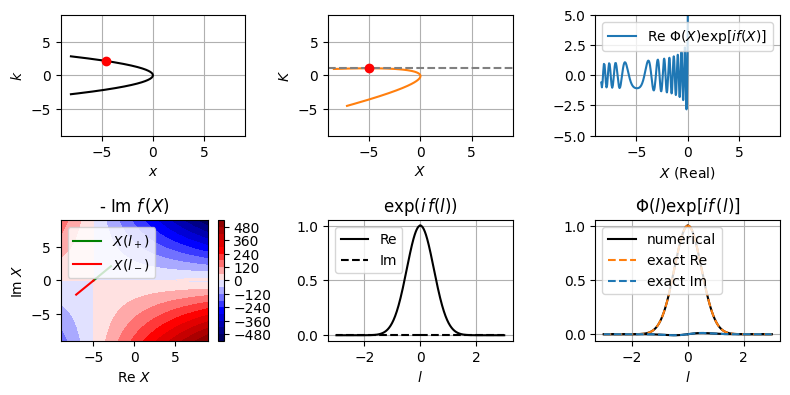

In [32]:
sliding_plot(it=60)
plt.savefig('./plots/airy_mgo_aac_algo_step.pdf')
plt.savefig('./plots/airy_mgo_aac_algo_step.svg')

## 7. Final MGO Field Construction

In [33]:
# Set ICs from Airy function
from scipy.signal import find_peaks

x0 = -8
k0 = np.sqrt(-x0)
omega0 = 1.0
ts, xs, ks, zs, nt = trace_ray_1D(x0, k0, omega0, tmin=0, tmax=2*k0, D=D, tsteps=500)

In [34]:
zdots, xdots, kdots = get_zdots(zs, omega0)
branch_masks, seeds, branch_ranges = get_branches(xdots)
Us = get_Us(zs)
Ns = get_Ns(zs, zdots, ts)
ray_field = Ns * Us

xsi = np.linspace(-8, 0, 1000)
field = superpose_ray_fields(phi0, x0, xs, branch_masks, ray_field)

In [ ]:
def plot_mgo_field(A, phase):    
    plt.plot(np.real(xsi), Ai(np.real(xsi)), 'k-', label=r'Exact Ai($x$)')
    plt.plot(np.real(xsi), np.real(A*np.exp(1j*phase)*field(xsi)), 'r-', label=r'MGO with AAC')
    plt.legend()
    plt.xlabel(r'$x$')
    plt.ylim(-1,1.5)
    plt.grid()

interact(plot_mgo_field, A=(0, 2, 0.01), phase=(-np.pi, np.pi, 2*np.pi/60))
plt.show()

interactive(children=(FloatSlider(value=1.0, description='A', max=2.0, step=0.01), FloatSlider(value=0.0, desc…

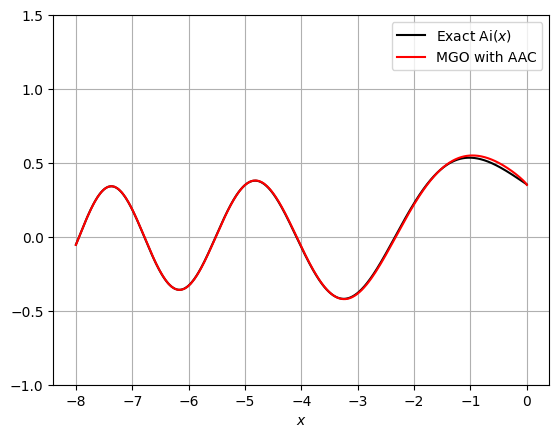

In [44]:
plot_mgo_field(A=1.03, phase=0)
plt.savefig('./plots/airy_mgo_aac_result.pdf')
plt.savefig('./plots/airy_mgo_aac_result.svg')
plt.savefig('./plots/airy_mgo_aac_result.png', dpi=300)